Financial Sentiment analysis with article headlines

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import matplotlib.pyplot as plt
import torch
import re
import tensorflow as tf
import string

from torch import nn

#the following two functions will allow to ignore padding of the input passed to the neural network
from torch.nn.utils.rnn import pack_padded_sequence 
from torch.nn.utils.rnn import pad_packed_sequence

import nltk
import spacy
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

2022-01-23 14:03:51.665742: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


I) Data loading and preprocessing

In [3]:
data = pd.read_csv('alldata.csv',delimiter=',',encoding='latin-1')
data.head(10)

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
5,positive,"For the last quarter of 2010 , Componenta 's n..."
6,positive,"In the third quarter of 2010 , net sales incre..."
7,positive,Operating profit rose to EUR 13.1 mn from EUR ...
8,positive,"Operating profit totalled EUR 21.1 mn , up fro..."
9,positive,TeliaSonera TLSN said the offer is in line wit...


In [4]:
data.columns = ['label','text']
data.head(10)

,label,text
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
5,positive,"For the last quarter of 2010 , Componenta 's n..."
6,positive,"In the third quarter of 2010 , net sales incre..."
7,positive,Operating profit rose to EUR 13.1 mn from EUR ...
8,positive,"Operating profit totalled EUR 21.1 mn , up fro..."
9,positive,TeliaSonera TLSN said the offer is in line wit...


In [5]:
#Checking for duplicates
data.text.duplicated().sum()

8

In [6]:
# Droping the duplicates
data = data.drop_duplicates(subset = ['text'], keep = 'first')
data.text.duplicated().sum()

0

In [7]:
# Checking for missing values
data.isna().sum()

label    0
text     0
dtype: int64

In [8]:
#Shuffling the dataset
data = data.sample(frac =1)

The number of unique words is: 10291


<AxesSubplot:>

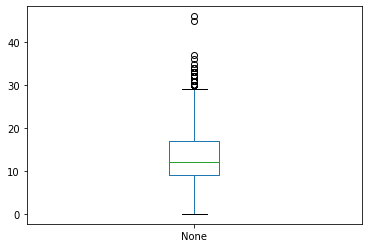

In [9]:

## Extracting the vocabulary (list of words) of the dataset

head_list = data['text'].tolist() # list of headlines


# Stop words removal and lemmatization
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def nltk_tokenizer(headline):
    #For the different steps of preprocessing, see this kaggle notebook https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing
    #Removes stop words and handles lemmatization . Returns the list of tokens of the word
    
    #URLs removal
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    headline = url_pattern.sub(r'', headline)
    
    #HTML removal
    html_pattern = re.compile('<.*?>')
    headline= html_pattern.sub(r'', headline)
    
    #Punctuation removal
    Punctuation = string.punctuation
    headline = headline.translate(str.maketrans('', '', Punctuation))
    
    #Tokenization
    head_tokens = word_tokenize(headline)    
    
    #stop words removal
    head_tokens = [token for token in head_tokens if not (token.lower() in stop_words) ] 
    
    #Lemmatization and conversion to lowercase
    head_tokens = [lemmatizer.lemmatize(token.lower()) for token in head_tokens]
    
    return head_tokens

head_list_token = [nltk_tokenizer(headline) for headline in head_list]
words_list = head_list_token[0]
for headline in head_list_token:
    words_list = words_list+headline
words_count = len(set(words_list)) #Number of unique words in the dataset
print("The number of unique words is:", words_count)

lenlist = pd.Series([len(headline) for headline in head_list_token]) #lengths of the headlines in the dataset
lenlist.plot(kind='box') #box plot for the headlines lengths

Looks like just a couple of headlines have more than 30 words

In [10]:
i = 0
for headline in head_list_token:
    if len(headline) > 30:
        #print(" ".join(review))
        i += 1
print("The proportion of reviews with more than 30 words is:", (i/len(head_list_token))*100,"%")

The proportion of reviews with more than 30 words is: 0.9716766590862104 %


When converting the sentences to vectors, I'll set a maximum length since only few words have a length higher than 30.

In [11]:
head_list = [" ".join(headline) for headline in head_list_token]

# tokenizing (and preprocessing) the reviews
max_words = int(words_count*0.8)# Number of most frequent words to use for the tokenization
tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words = max_words,split=" ") 
tokenizer.fit_on_texts(head_list) 

#vocab = tokenizer.word_index #vocabulary(a dictionnary containing each word and an integer that serves as index for the word )


## Converting the dataset to an appropriate format for the neural network

# Features
indice_lists = tokenizer.texts_to_sequences(head_list) #each review is converted to a list of integer, where an integer is the indice of the coresponding word in the vocabulary
indice_lists_pad = tf.keras.preprocessing.sequence.pad_sequences(indice_lists, maxlen=30,padding='pre',truncating='post', value=0.0) #add zeros for all the lists to have the same length. and truncate reviews that are too long.
indice_lists_pad = torch.Tensor.long(torch.from_numpy(indice_lists_pad)) #converting the padded sequences to a tensor



# Labels
label_list = data['label'].tolist()
label_dict = {"positive":0,"negative":1,"neutral":2}
label_list = torch.tensor( [label_dict[element] for element in label_list])


sample_size = label_list.size()[0]
split = int(0.8*sample_size) #spliting index for training and testing set


from torch.utils.data import Dataset
class training_data(Dataset):
    def __init__(self):
        self.samples = [indice_lists_pad[:split,:],label_list[:split]]
        #self.samples = self.samples.to(device)

    def __len__(self):
        return self.samples[1].size()[0]

    def __getitem__(self, idx):
        return self.samples[0][idx,:],self.samples[1][idx]

class testing_data(Dataset):
    def __init__(self):
        self.samples = [indice_lists_pad[split:,:],label_list[split:]]
        #self.samples = self.samples.to(device)

    def __len__(self):
        return self.samples[1].size()[0]

    def __getitem__(self, idx):
        return self.samples[0][idx,:],self.samples[1][idx]



In [12]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data(), batch_size=200)
test_dataloader = DataLoader(testing_data(), batch_size=200)

In [13]:
#number of unique indices
max_words+1

8233

In [14]:
#indice_list = indice_lists[0]
#for headline in indice_lists:
    #indice_list = indice_list+headline
#indices_count = len(set(indice_list)) #Number of unique words in the dataset
#print("The number of unique indicess is:", indices_count)

II) Model development (LSTM)

In [15]:
#LSTM
class myLSTM(nn.Module):
    def __init__(self,batch_size,input_size,hidden_size): # Data is inputed in the neural network by minibatches.
        super(myLSTM, self).__init__()
        self.batch_size = batch_size
        self.input_size = input_size #dimension of xi(vector representation of words)
        self.hidden_size = hidden_size #dimension of states St
        
        # Word embedding layer 
        self.embed = nn.Embedding(8233, 20,padding_idx = 0)
        
        # RNN layer
        self.lstm = nn.LSTM(input_size,hidden_size,batch_first = True)
        
        # Logistic regression layer
        self.linear = nn.Linear(hidden_size,3) #this will be applied to each element of the batch. No need to specify the size of the batch
        self.softmax = nn.Softmax(dim = 1) 
             #returns a vector of probabilities
             #there are 3 categories: positive, negative, neutral (The probabilities for the 3 classes are returned)
        
    def forward(self, x,batch_size):
       
        
        #print(batch_size)
        h_0 = torch.zeros(1,batch_size,self.hidden_size).to(device)
        c_0 = torch.randn(1,batch_size,self.hidden_size).to(device)
        
        x = x.to(device)
        e = self.embed(x)
        
        v = (x != 0).long()
        v = torch.sum(v,dim =1)
        featurelens = v.tolist()
        
        
        e = e.to(device)
        
        
        
        r = self.lstm(e,(h_0,c_0))
        
        logits = self.softmax(self.linear(r[1][0]))
        
        return logits
    
b_size = 200
i_size = 20
h_size = 50

mylstm = myLSTM(batch_size = b_size,input_size = i_size,hidden_size = h_size).to(device)
print(mylstm)

myLSTM(
  (embed): Embedding(8233, 20, padding_idx=0)
  (lstm): LSTM(20, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


III) Training and testing

In [16]:
# Training and testing loop setup

# Training loop
def train_loop(dataloader, model, loss_fn, optimizer,printer = False):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        Y = torch.unsqueeze(y,1)
        Y = Y.to(device)
        pred = torch.squeeze(model(X,y.size()[0]),0)
        #print("pred =",pred.size())
        
        loss = loss_fn(pred,torch.squeeze(Y,1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            if printer:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Test loop
def test_loop(dataloader, model, loss_fn,printer = False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            Y = torch.unsqueeze(y,1)
            Y = Y.to(device)
            pred = torch.squeeze(model(X,y.size()[0]),0)
            
            
            
            test_loss += loss_fn(pred,torch.squeeze(Y,1)).item()
            
            correct += (pred.argmax(1) == torch.squeeze(Y)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    #print("correct =",correct)
    if printer:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct #classification error

In [17]:
b_size = 200 # batch size
i_size = 20 # input size
h_dim = 50

 
########################################################################################
## LSTM
    
mylstm = myLSTM(batch_size = b_size,input_size = i_size,hidden_size = h_size).to(device)
    
    
## Training and testing

# Hyperparameters
learning_rate = 1
batch_size = 200
epochs = 3000

l_errors = [0]*epochs #will store classification errors

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.BCELoss()

# specifying that the optimizer is stochastic gradient descent
optimizer = torch.optim.SGD(mylstm.parameters(), lr=learning_rate)
#optimizer =torch.optim.Adam(mylstm.parameters(), lr=learning_rate)

#Training and testing
switch_lr1 = 0
switch_lr2 = 0
for t in range(epochs):
    if t%50==0:
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, mylstm, loss_fn, optimizer,True)
        l_errors[t] = test_loop(test_dataloader, mylstm, loss_fn,True)
    else:
        train_loop(train_dataloader, mylstm, loss_fn, optimizer)
        l_errors[t] = test_loop(test_dataloader, mylstm, loss_fn)
    if (l_errors[t] > 0.6) and (switch_lr1==0):
        switch_lr1 = 1
        for g in optimizer.param_groups:
            g['lr'] = 0.1
    if (l_errors[t] > 0.635) and (switch_lr2==0):
        switch_lr2 = 1
        for g in optimizer.param_groups:
            g['lr'] = 0.001
print("Done!")
    
lstm_error = min(l_errors) #storing the best classification result on the test set
    
#Table.append([h_dim,vrnn_error,lstm_error])

"""

#plotting
#plt.plot(range(1,101),v_errors,label = "Vanilla RNN", color = 'b')
plt.plot(range(1,101),l_errors,label = "LSTM", color = 'r')
plt.xlabel("Number of iterations")
plt.ylabel("classification error (in %)")
plt.legend()
plt.show()
"""
            

Epoch 1
-------------------------------
loss: 1.098608  [    0/ 3869]
Test Error: 
 Accuracy: 35.2%, Avg loss: 1.098608 

Epoch 51
-------------------------------
loss: 1.098595  [    0/ 3869]
Test Error: 
 Accuracy: 38.2%, Avg loss: 1.098598 

Epoch 101
-------------------------------
loss: 1.098580  [    0/ 3869]
Test Error: 
 Accuracy: 41.0%, Avg loss: 1.098586 

Epoch 151
-------------------------------
loss: 1.098562  [    0/ 3869]
Test Error: 
 Accuracy: 41.8%, Avg loss: 1.098572 

Epoch 201
-------------------------------
loss: 1.098539  [    0/ 3869]
Test Error: 
 Accuracy: 42.4%, Avg loss: 1.098553 

Epoch 251
-------------------------------
loss: 1.098508  [    0/ 3869]
Test Error: 
 Accuracy: 42.1%, Avg loss: 1.098526 

Epoch 301
-------------------------------
loss: 1.098464  [    0/ 3869]
Test Error: 
 Accuracy: 42.0%, Avg loss: 1.098486 

Epoch 351
-------------------------------
loss: 1.098394  [    0/ 3869]
Test Error: 
 Accuracy: 41.9%, Avg loss: 1.098424 

Epoch 401
-

'\n\n#plotting\n#plt.plot(range(1,101),v_errors,label = "Vanilla RNN", color = \'b\')\nplt.plot(range(1,101),l_errors,label = "LSTM", color = \'r\')\nplt.xlabel("Number of iterations")\nplt.ylabel("classification error (in %)")\nplt.legend()\nplt.show()\n'